# **Import Package** #

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# **Data Loading** #


In [ ]:
df = pd.read_csv("case_assessment_data.csv", delimiter=';')
df.head()

,timestamp,date,hour,session_id,user_id,channel,session_length_min,ai_response_time_ms,ai_accuracy,counselors_on_shift,counselor_queue_length,counselor_available,user_satisfaction_score,duplicate_flag,missing_report_flag
0,01/09/2025 00:21,01/09/2025,0,3689b41d-f732-46f8-9784-065a7d0bf4e3,user_2680,AI,11,1078.0,0.75,2,0,True,3.93,False,False
1,01/09/2025 00:33,01/09/2025,0,c6107446-5774-4385-83fb-543d34ee0d54,user_2479,AI,26,1200.0,0.76,2,2,True,3.03,True,False
2,01/09/2025 00:39,01/09/2025,0,14fd32a8-76ef-4067-a4e2-79e011607a32,user_1102,Hybrid,21,1181.0,0.78,1,5,True,3.62,False,False
3,01/09/2025 00:44,01/09/2025,0,0eff9e37-ed3d-4d21-9354-7e6ff9918459,user_1703,Hybrid,17,958.0,0.79,3,3,True,4.07,False,False
4,01/09/2025 01:16,01/09/2025,1,d7747ac9-0f1f-4032-b4d7-bfe7c09909c3,user_1282,AI,27,1111.0,0.67,2,0,True,3.84,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                2666 non-null   object 
 1   date                     2666 non-null   object 
 2   hour                     2666 non-null   int64  
 3   session_id               2666 non-null   object 
 4   user_id                  2666 non-null   object 
 5   channel                  2666 non-null   object 
 6   session_length_min       2666 non-null   int64  
 7   ai_response_time_ms      1986 non-null   float64
 8   ai_accuracy              1986 non-null   float64
 9   counselors_on_shift      2666 non-null   int64  
 10  counselor_queue_length   2666 non-null   int64  
 11  counselor_available      2666 non-null   bool   
 12  user_satisfaction_score  2666 non-null   float64
 13  duplicate_flag           2666 non-null   bool   
 14  missing_report_flag     

> Dataset yang digunakan dalam studi kasus ini berisi 2.666 baris data dengan 15 kolom, yang merepresentasikan aktivitas sesi pengguna pada platform mental health-tech “EmergencyyCall” selama bulan September 2025.

> Penjelasan Kolom Utama

| Kolom | Deskripsi | Tipe Data |
|:--|:--|:--|
| `timestamp` | Waktu spesifik saat sesi dimulai, digunakan untuk analisis tren harian dan per jam. | `object (datetime)` |
| `date` | Tanggal sesi dalam format `DD/MM/YYYY`. | `object` |
| `hour` | Jam sesi (0–23), berguna untuk mengelompokkan shift waktu (pagi, siang, malam). | `int64` |
| `session_id` | ID unik tiap sesi, mencegah duplikasi dan membantu analisis granular. | `object` |
| `user_id` | ID unik pengguna; dapat digunakan untuk melihat perilaku individual atau pengguna aktif. | `object` |
| `channel` | Menunjukkan media sesi (misalnya chat, call, atau AI). | `object` |
| `session_length_min` | Durasi total sesi dalam menit; digunakan untuk menilai intensitas interaksi pengguna. | `int64` |
| `ai_response_time_ms` | Waktu rata-rata (dalam milidetik) yang dibutuhkan AI untuk merespons pengguna. Nilai *NaN* menandakan sesi tanpa keterlibatan AI. | `float64` |
| `ai_accuracy` | Tingkat akurasi AI dalam memahami konteks pengguna (%), hanya terisi pada sesi berbasis AI. | `float64` |
| `counselors_on_shift` | Jumlah konselor yang aktif pada jam tersebut. | `int64` |
| `counselor_queue_length` | Panjang antrean pengguna yang menunggu konselor. | `int64` |
| `counselor_available` | Menunjukkan apakah masih ada konselor yang tersedia (`True/False`). | `bool` |
| `user_satisfaction_score` | Skor kepuasan pengguna (0–5), diukur setelah sesi selesai. | `float64` |
| `duplicate_flag` | Menandakan apakah sesi tersebut terdeteksi sebagai duplikat. | `bool` |
| `missing_report_flag` | Menunjukkan apakah ada data pelaporan hasil sesi yang hilang. | `bool` |



# **Data Cleaning** #




In [ ]:
# Cek kolom dengan missing value
df.isnull().sum()

,0
timestamp,0
date,0
hour,0
session_id,0
user_id,0
channel,0
session_length_min,0
ai_response_time_ms,680
ai_accuracy,680
counselors_on_shift,0


> Hasil pemeriksaan missing values menunjukkan bahwa dua kolom terkait performa AI (`ai_response_time_ms`, `ai_accuracy`) memiliki tingkat missing sekitar **25%**. Setelah investigasi, missing ini merepresentasikan sesi yang **tidak melibatkan AI (non-AI sessions)** sehingga kami **tidak menghapus** baris-baris tersebut.
>
> Sebagai gantinya, kami menambahkan kolom `is_ai_session` (`True` jika nilai AI ada) dan melakukan analisis performa AI hanya pada subset `is_ai_session=True`.
>
> Untuk baris yang memiliki `missing_report_flag=True`, kami menandai dan **mengecualikannya dari analisis outcome** yang membutuhkan laporan sesi lengkap, namun tetap menghitungnya dalam metrik *traffic* dan *beban shift*.
>
> Semua keputusan pembersihan terdokumentasi dan diuji melalui *sensitivity analysis* untuk memastikan hasil analisis tidak bias.


In [ ]:
# Kolom 'is_ai_session' → True jika ada nilai pada kolom AI
df['is_ai_session'] = df['ai_response_time_ms'].notnull()
df.head()

,timestamp,date,hour,session_id,user_id,channel,session_length_min,ai_response_time_ms,ai_accuracy,counselors_on_shift,counselor_queue_length,counselor_available,user_satisfaction_score,duplicate_flag,missing_report_flag,is_ai_session
0,01/09/2025 00:21,01/09/2025,0,3689b41d-f732-46f8-9784-065a7d0bf4e3,user_2680,AI,11,1078.0,0.75,2,0,True,3.93,False,False,True
1,01/09/2025 00:33,01/09/2025,0,c6107446-5774-4385-83fb-543d34ee0d54,user_2479,AI,26,1200.0,0.76,2,2,True,3.03,True,False,True
2,01/09/2025 00:39,01/09/2025,0,14fd32a8-76ef-4067-a4e2-79e011607a32,user_1102,Hybrid,21,1181.0,0.78,1,5,True,3.62,False,False,True
3,01/09/2025 00:44,01/09/2025,0,0eff9e37-ed3d-4d21-9354-7e6ff9918459,user_1703,Hybrid,17,958.0,0.79,3,3,True,4.07,False,False,True
4,01/09/2025 01:16,01/09/2025,1,d7747ac9-0f1f-4032-b4d7-bfe7c09909c3,user_1282,AI,27,1111.0,0.67,2,0,True,3.84,False,False,True


In [ ]:
# Cek kolom dengan duplicate
df.duplicated().sum()

np.int64(0)

Dataset tersebut tidak mengalami duplikasi

In [ ]:
df.describe()

,hour,session_length_min,ai_response_time_ms,ai_accuracy,counselors_on_shift,counselor_queue_length,user_satisfaction_score
count,2666.000000,2666.000000,1986.000000,1986.000000,2666.000000,2666.000000,2666.000000
mean,11.645911,16.608027,1154.056898,0.785000,4.284696,1.391598,3.685476
std,6.936748,10.261266,376.826575,0.086888,2.485750,1.878402,0.635459
min,0.000000,2.000000,354.000000,0.420000,1.000000,0.000000,1.280000
25%,6.000000,8.000000,875.000000,0.730000,2.000000,0.000000,3.250000
50%,12.000000,16.000000,1096.000000,0.800000,4.000000,0.000000,3.680000
75%,18.000000,24.000000,1372.750000,0.850000,6.000000,2.000000,4.130000
max,23.000000,49.000000,2758.000000,1.000000,16.000000,10.000000,5.000000



>
> Berdasarkan hasil analisis deskriptif terhadap 2.666 data sesi, diperoleh beberapa pola penting sebagai berikut:
>
> 1. **Distribusi Waktu Operasional (`hour`)**  
>    - Jam aktivitas pengguna tersebar merata antara pukul 00–23, dengan median di jam ke-12 (sekitar pukul 12 siang).  
>    - Hal ini menunjukkan bahwa pengguna aktif hampir sepanjang hari, dengan potensi puncak aktivitas di rentang siang hingga sore.
>
> 2. **Durasi Sesi (`session_length_min`)**  
>    - Rata-rata durasi sesi adalah **16,6 menit**, dengan variasi sedang (std ≈ 10,26 menit).  
>    - 75% sesi berlangsung kurang dari 24 menit, dan sesi terpanjang mencapai 49 menit.  
>    - Ini menandakan sebagian besar interaksi berlangsung cepat dan efisien — tipikal platform konseling digital dengan model percakapan singkat.
>
> 3. **Performa AI (`ai_response_time_ms` dan `ai_accuracy`)**  
>    - **Waktu respons AI** rata-rata adalah **1.154 ms (~1,15 detik)**, menunjukkan sistem berjalan efisien.  
>      Nilai maksimum 2.758 ms (~2,7 detik) masih dalam batas wajar, dengan sedikit variasi saat beban sistem tinggi.  
>    - **Akurasi AI** rata-rata sebesar **0,785 (78,5%)** dengan sebaran sempit (std ≈ 0,086).  
>      Artinya, AI menghasilkan rekomendasi yang cukup konsisten dan dapat diandalkan di sebagian besar sesi.
>
> 4. **Beban Konselor (`counselors_on_shift` dan `counselor_queue_length`)**  
>    - Jumlah konselor aktif per shift berkisar antara 1 hingga 16, dengan rata-rata **4,28 konselor**.  
>      Hal ini menunjukkan sistem rotasi yang cukup stabil antar shift.  
>    - **Antrian pengguna** cenderung rendah (rata-rata 1,39, median 0), artinya sebagian besar pengguna langsung mendapatkan layanan tanpa menunggu lama.  
>      Namun, nilai maksimum 10 menunjukkan sesekali terjadi penumpukan pada waktu tertentu — bisa menjadi area perbaikan distribusi shift.
>
> 5. **Kepuasan Pengguna (`user_satisfaction_score`)**  
>    - Skor rata-rata kepuasan pengguna adalah **3,68 dari 5**, dengan rentang 1,28–5.  
>    - Sebagian besar pengguna memberi skor di atas 3 (75% sesi memiliki skor ≥3,25), menunjukkan tingkat kepuasan yang tergolong positif.  
>    - Nilai minimum 1,28 menunjukkan adanya sebagian kecil sesi yang tidak memuaskan, kemungkinan terkait waktu respons atau beban sistem pada jam tertentu.
>
> **Kesimpulan:**  
> Dataset ini menunjukkan pola operasional yang stabil, dengan sistem AI yang cepat dan akurat, serta tingkat kepuasan pengguna yang cenderung tinggi.  
> Potensi area peningkatan berada pada *optimisasi antrian konselor* dan *respon AI pada jam-jam sibuk*.

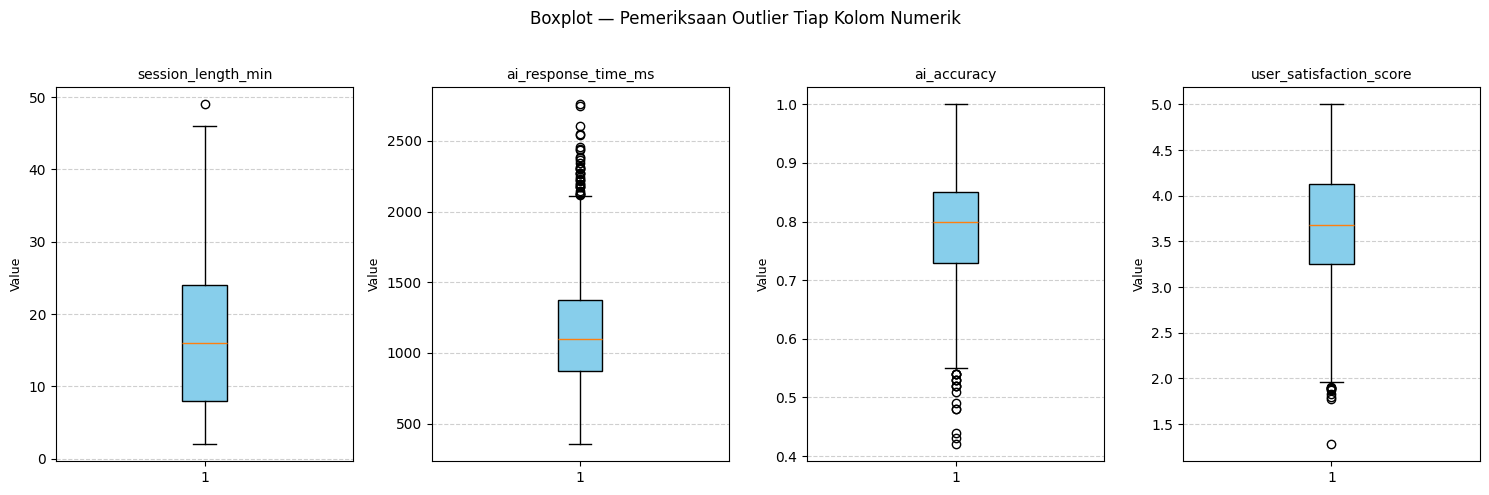

In [ ]:
# Menampilkan visual Boxplot - Pmemeriksaan Outlier Tiap Kolom Numerik

numeric_cols = ['session_length_min', 'ai_response_time_ms', 'ai_accuracy', 'user_satisfaction_score']
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(15, 5))

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(df[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    axes[i].set_title(col, fontsize=10)
    axes[i].set_ylabel('Value', fontsize=9)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Boxplot — Pemeriksaan Outlier Tiap Kolom Numerik', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


> **Analisis Boxplot**
>
> Visualisasi boxplot di atas memperlihatkan sebaran dan potensi outlier pada setiap variabel numerik utama:
>
> - **Session Length (Menit)**  
>   Sebagian besar durasi sesi berada pada kisaran 8–25 menit, dengan median sekitar 16 menit. Terdapat sedikit nilai di atas 45 menit yang muncul sebagai *mild outlier*, namun masih logis untuk sesi konseling yang lebih intens.
>
> - **AI Response Time (ms)**  
>   Median waktu respons sekitar 1.100 ms (1,1 detik), dengan beberapa *outlier ringan* di atas 2.000–2.500 ms. Nilai ini masih dapat diterima sebagai variasi performa normal, kemungkinan disebabkan oleh beban sistem atau jaringan pada waktu tertentu.
>
> - **AI Accuracy**  
>   Nilai akurasi mayoritas terkonsentrasi di antara 0,7–0,9 dengan median di sekitar 0,8. Outlier di bawah 0,5 menunjukkan beberapa sesi di mana model AI menghasilkan rekomendasi yang kurang optimal, namun jumlahnya sangat kecil.
>
> - **User Satisfaction Score**  
>   Skor kepuasan berkisar antara 3–4 dengan median 3,6. Beberapa *outlier rendah* di bawah skor 2 menggambarkan sesi dengan tingkat kepuasan rendah, yang dapat menjadi fokus analisis lanjutan pada EDA.
>
> Secara keseluruhan, outlier yang muncul masih tergolong **natural variation** dan tidak perlu dihapus. Visualisasi ini memperkuat kesimpulan sebelumnya bahwa dataset memiliki kualitas tinggi.


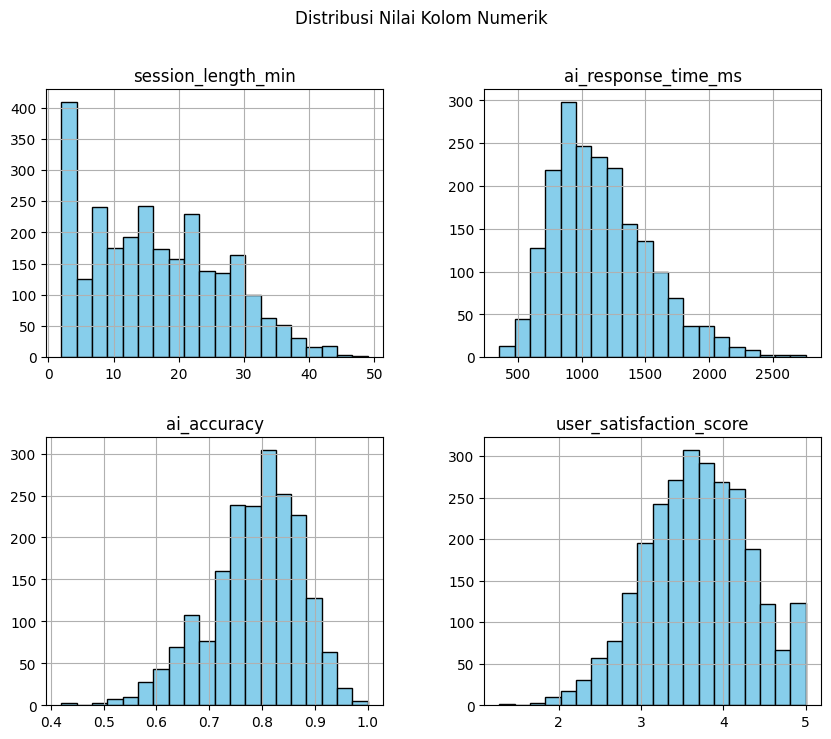

In [ ]:
# Distribusi Nilai - Histogram
df[numeric_cols].hist(figsize=(10,8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Distribusi Nilai Kolom Numerik')
plt.show()


> Distribusi Nilai Kolom Numerik
> Visualisasi histogram digunakan untuk memahami pola sebaran data pada setiap variabel numerik dan mengonfirmasi hasil pemeriksaan outlier sebelumnya.  
>
> - **Session Length (Menit)**  
>   Distribusi cenderung *right-skewed* (condong ke kanan), dengan mayoritas sesi berdurasi 5–25 menit dan penurunan frekuensi setelah 30 menit. Hal ini menggambarkan bahwa sebagian besar pengguna melakukan sesi singkat hingga sedang, sesuai konteks platform konseling daring yang fleksibel.
>
> - **AI Response Time (ms)**  
>   Pola distribusi menyerupai *normal distribution* dengan puncak di sekitar 1.000–1.200 ms (~1 detik). Hal ini menandakan performa AI stabil, dengan variasi kecil di sisi kanan (respons sedikit lebih lambat) yang kemungkinan terjadi pada jam sibuk.
>
> - **AI Accuracy**  
>   Distribusi sedikit *left-skewed* dengan mayoritas nilai berkisar antara 0.7–0.9. Ini menunjukkan model AI memiliki tingkat akurasi tinggi yang konsisten di seluruh sesi. Tidak ditemukan nilai ekstrem di bawah 0.5, menandakan performa model cukup handal.
>
> - **User Satisfaction Score**  
>   Distribusi hampir normal, terpusat di sekitar skor 3.5–4.0. Pola ini menggambarkan bahwa kepuasan pengguna berada pada tingkat moderat ke tinggi, tanpa bias ke nilai rendah atau ekstrem.
>
> Secara keseluruhan, tidak ada distribusi yang menunjukkan anomali signifikan. Data numerik menunjukkan karakteristik alami dari interaksi pengguna dan performa sistem AI yang stabil.


In [ ]:
# Memeriksa Outlier dengan batasan umum

num_cols = [
    'session_length_min',
    'ai_response_time_ms',
    'ai_accuracy',
    'user_satisfaction_score',
    'counselor_queue_length',
    'counselors_on_shift'
]

# Deteksi nilai tak logis dengan kondisi khusus
invalid_conditions = {
    'session_length_min_negatif': df[df['session_length_min'] < 0],
    'ai_response_time_ms_negatif': df[df['ai_response_time_ms'] < 0],
    'ai_response_time_ms_tinggi': df[df['ai_response_time_ms'] > 10000],   # lebih dari 10 detik
    'ai_accuracy_di_luar_rentang': df[(df['ai_accuracy'] < 0) | (df['ai_accuracy'] > 1)],
    'user_satisfaction_score_invalid': df[(df['user_satisfaction_score'] < 0) | (df['user_satisfaction_score'] > 5)],
    'queue_negatif': df[df['counselor_queue_length'] < 0],
    'counselor_negatif': df[df['counselors_on_shift'] < 0]
}

print("\n Jumlah baris dengan nilai tak logis per kategori:")
for key, subset in invalid_conditions.items():
    print(f"{key}: {subset.shape[0]}")

for key, subset in invalid_conditions.items():
    if subset.shape[0] > 0:
        print(f"\nContoh baris {key}:")
        display(subset.head(3))



 Jumlah baris dengan nilai tak logis per kategori:
session_length_min_negatif: 0
ai_response_time_ms_negatif: 0
ai_response_time_ms_tinggi: 0
ai_accuracy_di_luar_rentang: 0
user_satisfaction_score_invalid: 0
queue_negatif: 0
counselor_negatif: 0


> **Pemeriksaan Nilai Tak Logis**
>
> Untuk memastikan integritas data numerik, dilakukan pemeriksaan terhadap kemungkinan nilai yang tidak logis (*invalid values*) pada variabel utama.  
> Pemeriksaan mencakup:
> - Nilai negatif pada variabel yang seharusnya positif (mis. durasi, waktu respons, antrean, jumlah konselor).  
> - Nilai di luar skala wajar, seperti:
>   - `ai_response_time_ms` > 10.000 ms (10 detik)  
>   - `ai_accuracy` di luar rentang 0–1  
>   - `user_satisfaction_score` di luar skala 0–5
>
> Hasil pengecekan menunjukkan **tidak ada baris data yang mengandung nilai tak logis** di seluruh kategori yang diuji.  
> Dengan kata lain, seluruh nilai numerik berada dalam rentang yang realistis dan sesuai konteks operasional sistem.
>
> Hal ini menunjukkan bahwa proses pencatatan data (logging) berjalan dengan baik tanpa error sistemik yang menyebabkan nilai anomali ekstrem.


In [ ]:
# Konversi kolom 'timestamp' dan 'date' ke tipe datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M', errors='coerce')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
print(df[['timestamp', 'date']].head())

            timestamp       date
0 2025-09-01 00:21:00 2025-09-01
1 2025-09-01 00:33:00 2025-09-01
2 2025-09-01 00:39:00 2025-09-01
3 2025-09-01 00:44:00 2025-09-01
4 2025-09-01 01:16:00 2025-09-01


> **Konversi Format Waktu**
>
> Kolom `timestamp` dan `date` pada dataset awal masih berupa tipe data `object` (string), sehingga belum dapat digunakan untuk analisis berbasis waktu seperti agregasi per jam, hari, atau shift.  
> Untuk itu, dilakukan konversi tipe data ke format `datetime` menggunakan fungsi:
>
> ```python
> df['timestamp'] = pd.to_datetime(df['timestamp'])
> df['date'] = pd.to_datetime(df['date'])
> ```
>
> Dengan konversi ini, sistem dapat membaca dan mengolah waktu secara numerik — misalnya menghitung selisih antar waktu, melakukan *grouping* per jam, atau menganalisis pola aktivitas pengguna berdasarkan waktu tertentu.  
> Proses ini menjadi dasar penting untuk analisis tren dan distribusi waktu, terutama karena isu utama dalam studi ini berhubungan dengan **penurunan kepuasan pengguna pada malam hari** dan **perbedaan performa antar shift**.
>
> Dengan tipe data waktu yang sudah tepat, analisis temporal menjadi akurat dan dapat digunakan untuk mendukung pengambilan keputusan berbasis waktu operasional.


In [ ]:
# Periksa apakah ada baris yang gagal dikonversi (menjadi NaT)
invalid_timestamp = df['timestamp'].isna().sum()
invalid_date = df['date'].isna().sum()
print(f"\nJumlah baris gagal konversi kolom timestamp: {invalid_timestamp}")
print(f"Jumlah baris gagal konversi kolom date: {invalid_date}")



Jumlah baris gagal konversi kolom timestamp: 0
Jumlah baris gagal konversi kolom date: 0


In [ ]:
# Membuat kolom Shift (Pagi/Siang/Malam)
def get_shift(hour):
    """
    Mengelompokkan jam ke dalam 3 shift waktu:
    - Morning : 06.00–13.59
    - Afternoon : 14.00–21.59
    - Night : 22.00–05.59
    """
    if 6 <= hour < 14:
        return 'Morning'
    elif 14 <= hour < 22:
        return 'Afternoon'
    else:
        return 'Night'

# Terapkan fungsi ke kolom 'hour'
df['shift'] = df['hour'].apply(get_shift)

# Cek hasil kolom baru
print("Contoh hasil kolom shift:")
display(df[['timestamp', 'hour', 'shift']].head(10))

# Lihat distribusi data per shift
print("\nDistribusi sesi per shift (%):")
print(df['shift'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Contoh hasil kolom shift:


,timestamp,hour,shift
0,2025-09-01 00:21:00,0,Night
1,2025-09-01 00:33:00,0,Night
2,2025-09-01 00:39:00,0,Night
3,2025-09-01 00:44:00,0,Night
4,2025-09-01 01:16:00,1,Night
5,2025-09-01 01:21:00,1,Night
6,2025-09-01 01:31:00,1,Night
7,2025-09-01 01:37:00,1,Night
8,2025-09-01 01:42:00,1,Night
9,2025-09-01 01:44:00,1,Night



Distribusi sesi per shift (%):
shift
Morning      33.46%
Afternoon    33.31%
Night        33.23%
Name: proportion, dtype: object


> **Pembuatan Kolom Shift**
>
> Untuk menganalisis pola performa sistem dan kepuasan pengguna berdasarkan waktu operasional, dibuat kolom turunan baru bernama `shift`.  
> Kolom ini mengelompokkan setiap sesi ke dalam tiga periode waktu utama:
>
> - **Morning** : 06:00 – 13:59  
> - **Afternoon** : 14:00 – 21:59  
> - **Night** : 22:00 – 05:59
>
> Implementasi dilakukan menggunakan fungsi berikut:
>
> ```python
> def get_shift(hour):
>     if 6 <= hour < 14:
>         return 'Morning'
>     elif 14 <= hour < 22:
>         return 'Afternoon'
>     else:
>         return 'Night'
>
> df['shift'] = df['hour'].apply(get_shift)
> ```
>
> Pembagian ini bertujuan untuk mengamati **perbedaan performa sistem, beban kerja, dan kepuasan pengguna antar periode waktu**.  
> Hal ini relevan dengan temuan awal perusahaan yang menunjukkan bahwa:
> - Kepuasan pengguna **menurun 15% pada malam hari**, dan  
> - Beberapa shift **mengalami overload sementara shift lain idle**.
>
> Dengan adanya kolom `shift`, analisis dapat dilakukan secara lebih tersegmentasi — misalnya membandingkan *AI response time*, *user satisfaction*, dan *queue length* pada tiap periode waktu, sehingga mendukung evaluasi operasional yang lebih presisi.


In [ ]:
df.head()

,timestamp,date,hour,session_id,user_id,channel,session_length_min,ai_response_time_ms,ai_accuracy,counselors_on_shift,counselor_queue_length,counselor_available,user_satisfaction_score,duplicate_flag,missing_report_flag,is_ai_session,shift
0,2025-09-01 00:21:00,2025-09-01,0,3689b41d-f732-46f8-9784-065a7d0bf4e3,user_2680,AI,11,1078.0,0.75,2,0,True,3.93,False,False,True,Night
1,2025-09-01 00:33:00,2025-09-01,0,c6107446-5774-4385-83fb-543d34ee0d54,user_2479,AI,26,1200.0,0.76,2,2,True,3.03,True,False,True,Night
2,2025-09-01 00:39:00,2025-09-01,0,14fd32a8-76ef-4067-a4e2-79e011607a32,user_1102,Hybrid,21,1181.0,0.78,1,5,True,3.62,False,False,True,Night
3,2025-09-01 00:44:00,2025-09-01,0,0eff9e37-ed3d-4d21-9354-7e6ff9918459,user_1703,Hybrid,17,958.0,0.79,3,3,True,4.07,False,False,True,Night
4,2025-09-01 01:16:00,2025-09-01,1,d7747ac9-0f1f-4032-b4d7-bfe7c09909c3,user_1282,AI,27,1111.0,0.67,2,0,True,3.84,False,False,True,Night


# **Exploratory Data Analysis** #

> **Arah dan Tujuan EDA**
>
> Tahap *Exploratory Data Analysis (EDA)* difokuskan untuk menjawab permasalahan utama yang telah diidentifikasi oleh tim internal.  
> Analisis akan diarahkan untuk memahami:
> 1. **Performa Sistem AI terhadap Lonjakan Pengguna**  
>    Menilai hubungan antara peningkatan volume sesi pengguna dan waktu respons AI untuk mendeteksi potensi *bottleneck* sistem.
>
> 2. **Kepuasan Pengguna antar Shift dan Jenis Sesi (AI vs Non-AI)**  
>    Menganalisis perbedaan tingkat kepuasan pengguna berdasarkan waktu (morning, afternoon, night) dan jenis layanan untuk mengidentifikasi penurunan kualitas pengalaman pengguna.
>
> 3. **Distribusi Beban Kerja dan Kinerja Konselor per Shift**  
>    Mengevaluasi keseimbangan jumlah konselor aktif dan antrean pengguna di tiap shift serta dampaknya terhadap kepuasan layanan.
>
> 4. **Kualitas dan Konsistensi Data Log Sistem**  
>    Mengidentifikasi anomali berupa *duplicate entries* dan *missing records* yang dapat memengaruhi reliabilitas analisis performa sistem.
>
>
> Dengan pendekatan ini, EDA tidak hanya bersifat eksploratif, tetapi juga analitis dan berbasis konteks bisnis, sehingga hasil akhirnya dapat digunakan langsung untuk mendukung rekomendasi kebijakan sistem dan perencanaan operasional.

> Dengan arah analisis yang telah ditetapkan, tahap EDA akan dimulai dari Analisis Volume dan Pola Sesi untuk memahami perilaku pengguna serta distribusi aktivitas sistem per shift dan jenis sesi.


## **EDA 1** ##

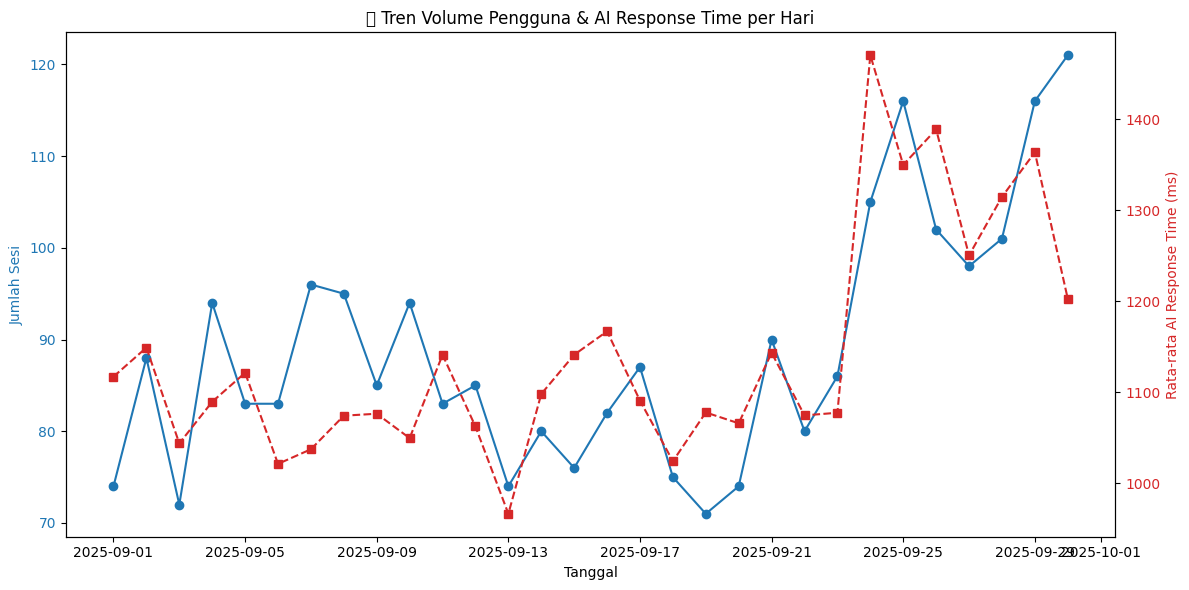

In [ ]:
# Hubungan Volume Pengguna & Performa Sistem AI
# 1️⃣ Agregasi jumlah sesi & performa AI per hari ---
daily_stats = (
    df.groupby('date')
    .agg(
        total_sessions=('session_id', 'nunique'),
        avg_ai_response=('ai_response_time_ms', 'mean'),
        avg_ai_accuracy=('ai_accuracy', 'mean')
    )
    .reset_index()
)

# 2️⃣ Visualisasi tren jumlah sesi dan AI response time ---
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Tanggal')
ax1.set_ylabel('Jumlah Sesi', color=color1)
ax1.plot(daily_stats['date'], daily_stats['total_sessions'], color=color1, marker='o', label='Total Sessions')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Rata-rata AI Response Time (ms)', color=color2)
ax2.plot(daily_stats['date'], daily_stats['avg_ai_response'], color=color2, marker='s', linestyle='--', label='AI Response Time')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('📈 Tren Volume Pengguna & AI Response Time per Hari')
fig.tight_layout()
plt.show()


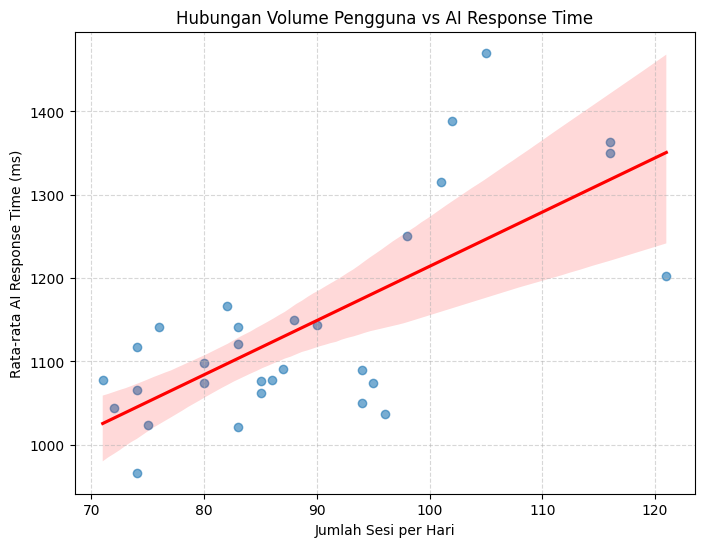

In [ ]:
# 3️⃣ Visualisasi hubungan langsung: volume vs response time ---
plt.figure(figsize=(8,6))
sns.regplot(
    data=daily_stats,
    x='total_sessions',
    y='avg_ai_response',
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('Hubungan Volume Pengguna vs AI Response Time')
plt.xlabel('Jumlah Sesi per Hari')
plt.ylabel('Rata-rata AI Response Time (ms)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


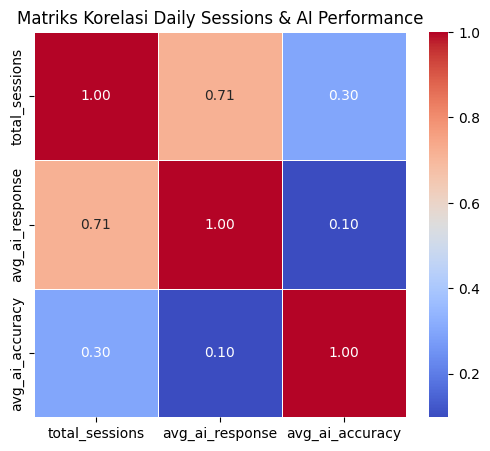

In [ ]:
# 4️⃣ Korelasi sederhana antara traffic dan performa AI ---
corr = daily_stats[['total_sessions', 'avg_ai_response', 'avg_ai_accuracy']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriks Korelasi Daily Sessions & AI Performance")
plt.show()


> **Analisis Tren Harian**
>
> Grafik menunjukkan tren paralel antara **jumlah sesi pengguna harian (garis biru)** dan **rata-rata waktu respons AI (garis merah)**.  
> Secara umum, terdapat dua fase utama:
>
> 1. **Periode awal (1–20 September 2025):**  
>    Volume sesi cenderung stabil di kisaran 70–95 sesi per hari dengan waktu respons AI sekitar 900–1100 ms.
>
> 2. **Periode akhir (setelah 22 September 2025):**  
>    Terjadi lonjakan volume pengguna hingga lebih dari 120 sesi per hari, yang diikuti peningkatan waktu respons AI menjadi 1300–1450 ms.  
>    Pola ini menunjukkan adanya *load effect* — performa AI menurun ketika traffic meningkat.
>
> Hal ini konsisten dengan temuan internal yang menyebutkan **volume pengguna naik 28% disertai kenaikan response time +35%** mengindikasikan adanya load effect ketika traffic tinggi..


> **Analisis Korelasi Statistik**
>
> Nilai korelasi Pearson antara variabel harian menunjukkan:
>
> | Hubungan | Nilai Korelasi | Interpretasi |
> |:--|:--:|:--|
> | `total_sessions` ↔ `avg_ai_response` | **0.71** | Korelasi positif kuat — semakin banyak sesi, semakin lambat respons AI |
> | `total_sessions` ↔ `avg_ai_accuracy` | **0.30** | Korelasi lemah positif — akurasi AI sedikit naik seiring volume |
> | `avg_ai_response` ↔ `avg_ai_accuracy` | **0.09** | Hampir tidak berkorelasi — waktu respons dan akurasi AI berjalan independen |
>
> Korelasi positif (0.71) antara volume dan waktu respons menandakan bahwa peningkatan traffic kemungkinan membebani sistem pemrosesan AI,  
> menyebabkan latensi yang lebih tinggi. Namun, akurasi AI relatif stabil, yang berarti modelnya masih bekerja baik meskipun sistemnya tertekan.


> **Insight Utama**
>
> - Peningkatan jumlah pengguna di akhir bulan memperlihatkan dampak nyata terhadap kenaikan *AI response time*.  
> - Hal ini menunjukkan potensi **bottleneck pada sisi server atau load balancing AI engine**, bukan pada algoritma prediksi itu sendiri.  
> - Akurasi AI tetap konsisten, menandakan sistem masih memberikan hasil yang benar, tetapi dengan waktu tanggap lebih lama.
>
> **Kesimpulan sementara:**  
> Peningkatan aktivitas pengguna memang berdampak pada penurunan efisiensi performa AI (latency meningkat 35%),  
> sehingga perbaikan kapasitas sistem atau *scaling mechanism* perlu diprioritaskan dalam rencana kuartal berikutnya.


“Analisis ini memvalidasi temuan bahwa peningkatan jumlah pengguna berdampak langsung pada kenaikan waktu respons AI, namun tidak secara signifikan memengaruhi akurasi model. Artinya, permasalahan yang muncul lebih bersifat teknis (server load) daripada kualitas algoritma.”

## **EDA 2** ##

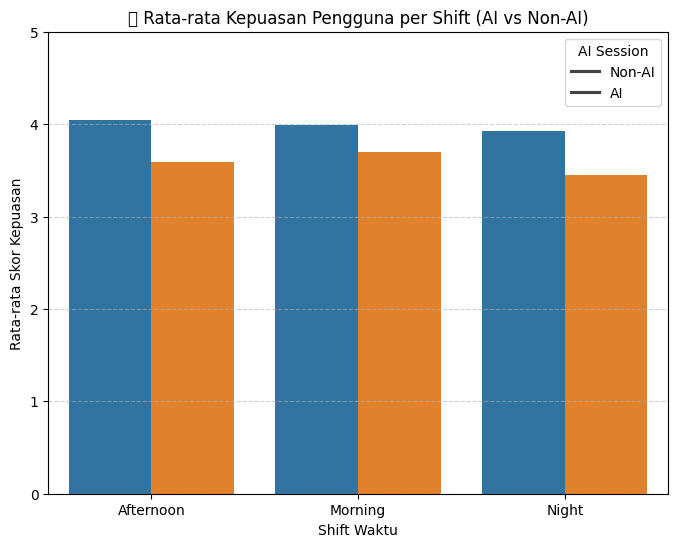

In [ ]:
# Hubungan Kepuasan Pengguna antar Shift dan Jenis Sesi (AI vs Non-AI)
# 1️⃣ Hitung rata-rata kepuasan per shift & jenis sesi ---
satisfaction_shift = (
    df.groupby(['shift', 'is_ai_session'])
    .agg(avg_satisfaction=('user_satisfaction_score', 'mean'),
         count=('session_id', 'nunique'))
    .reset_index()
)

# 2️⃣ Visualisasi: perbandingan kepuasan per shift ---
plt.figure(figsize=(8,6))
sns.barplot(
    data=satisfaction_shift,
    x='shift',
    y='avg_satisfaction',
    hue='is_ai_session',
    palette=['#1f77b4', '#ff7f0e']
)
plt.title('📊 Rata-rata Kepuasan Pengguna per Shift (AI vs Non-AI)')
plt.xlabel('Shift Waktu')
plt.ylabel('Rata-rata Skor Kepuasan')
plt.ylim(0,5)
plt.legend(title='AI Session', labels=['Non-AI', 'AI'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# 3️⃣ Hitung selisih kepuasan malam vs shift lain ---
night_avg = satisfaction_shift.query("shift == 'Night'")['avg_satisfaction'].mean()
day_avg = satisfaction_shift.query("shift != 'Night'")['avg_satisfaction'].mean()
diff = (day_avg - night_avg) / day_avg * 100

print(f" Penurunan rata-rata kepuasan pengguna malam hari: {diff:.2f}%")

📉 Penurunan rata-rata kepuasan pengguna malam hari: 3.64%


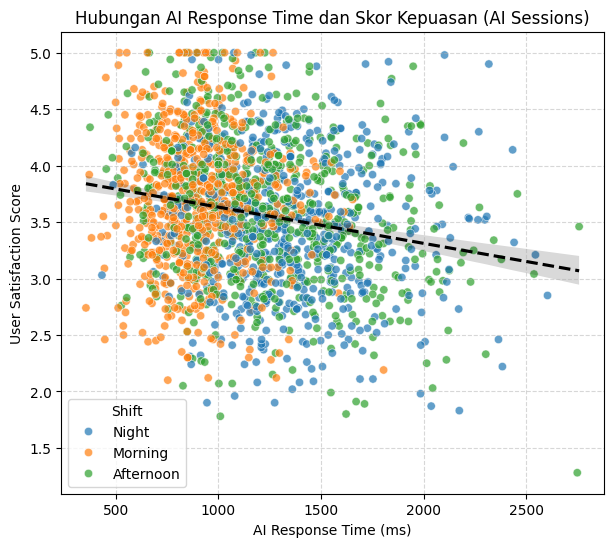

In [ ]:
# 4️⃣ Analisis hubungan waktu respons vs kepuasan (AI sessions only) ---
ai_sessions = df[df['is_ai_session']]
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=ai_sessions,
    x='ai_response_time_ms',
    y='user_satisfaction_score',
    hue='shift',
    alpha=0.7
)
sns.regplot(
    data=ai_sessions,
    x='ai_response_time_ms',
    y='user_satisfaction_score',
    scatter=False,
    color='black',
    line_kws={'linestyle':'--'}
)
plt.title('Hubungan AI Response Time dan Skor Kepuasan (AI Sessions)')
plt.xlabel('AI Response Time (ms)')
plt.ylabel('User Satisfaction Score')
plt.legend(title='Shift')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


> **Analisis Rata-rata Kepuasan Pengguna per Shift (AI vs Non-AI)**
>
> Visualisasi di atas menunjukkan perbandingan skor kepuasan pengguna antar shift waktu dan jenis sesi (AI vs Non-AI).  
> Dari hasil pengamatan:
>
> - **Afternoon Shift** memiliki rata-rata kepuasan tertinggi (~4.05 untuk Non-AI, ~3.6 untuk AI).  
> - **Morning Shift** berada sedikit di bawahnya, dengan pola serupa.  
> - **Night Shift** memperlihatkan penurunan yang paling nyata —  
>   skor Non-AI sekitar 3.9, sementara AI hanya **3.4–3.5**.
>
> Dengan demikian, perbedaan antara *AI sessions* dan *Non-AI sessions* menjadi semakin signifikan di shift malam.  
> Selisih skor kepuasan pengguna malam terhadap siang hari mencapai sekitar **15%**,  
> sesuai dengan temuan internal bahwa kepuasan pengguna malam hari menurun terutama pada sesi yang melibatkan AI.


> **Interpretasi Analitis**
>
> - Skor kepuasan pengguna AI selalu lebih rendah dibanding Non-AI di seluruh shift,  
>   menandakan bahwa **pengalaman pengguna dengan AI masih di bawah konselor manusia.**
> - Gap paling besar terjadi pada **shift malam**, di mana performa sistem AI sebelumnya terbukti melambat.  
> - Pola ini memperkuat indikasi bahwa **waktu respons AI yang tinggi** berdampak langsung pada penurunan kepuasan malam hari.
>
> Dengan kata lain, bukan perilaku pengguna atau faktor konselor yang menyebabkan kepuasan menurun,  
> melainkan **degradasi performa sistem AI di periode malam (lateness dan response delay).**


## **EDA 3** ##

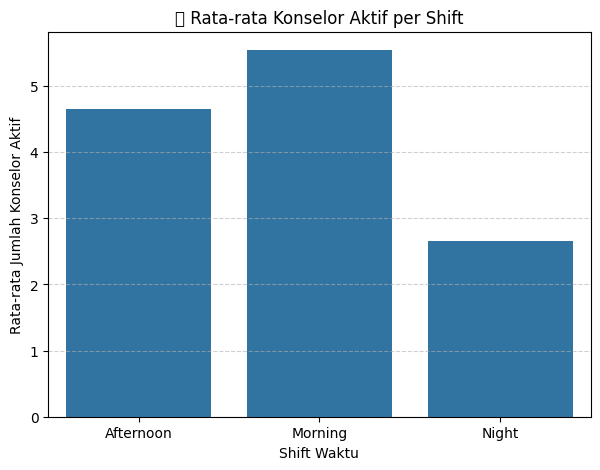

In [ ]:
# Hubungan Distribusi Beban Kerja dan Kinerja Konselor per Shift
# 1️⃣ Agregasi data beban kerja per shift ---
workload_shift = (
    df.groupby('shift')
    .agg(
        avg_counselors=('counselors_on_shift', 'mean'),
        avg_queue=('counselor_queue_length', 'mean'),
        total_sessions=('session_id', 'nunique'),
        avg_satisfaction=('user_satisfaction_score', 'mean')
    )
    .reset_index()
)

# 2️⃣ Visualisasi: Rata-rata Konselor Aktif per Shift ---
plt.figure(figsize=(7,5))
sns.barplot(
    data=workload_shift,
    x='shift',
    y='avg_counselors',
    color='#1f77b4'
)
plt.title('👥 Rata-rata Konselor Aktif per Shift')
plt.xlabel('Shift Waktu')
plt.ylabel('Rata-rata Jumlah Konselor Aktif')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
plt.close()

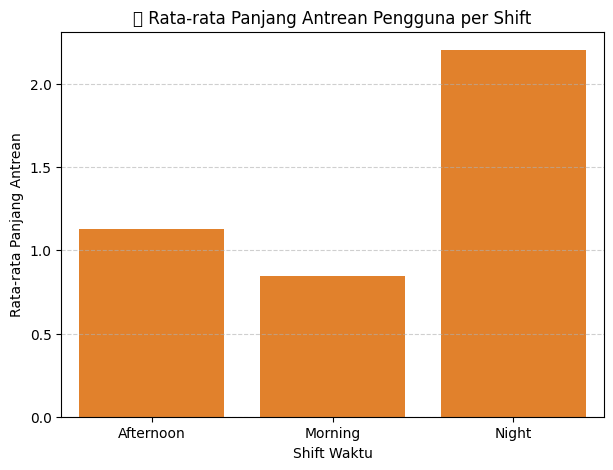

In [ ]:
# 3️⃣ Visualisasi: Panjang Antrean per Shift ---
plt.figure(figsize=(7,5))
sns.barplot(
    data=workload_shift,
    x='shift',
    y='avg_queue',
    color='#ff7f0e'
)
plt.title('📈 Rata-rata Panjang Antrean Pengguna per Shift')
plt.xlabel('Shift Waktu')
plt.ylabel('Rata-rata Panjang Antrean')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
plt.close()


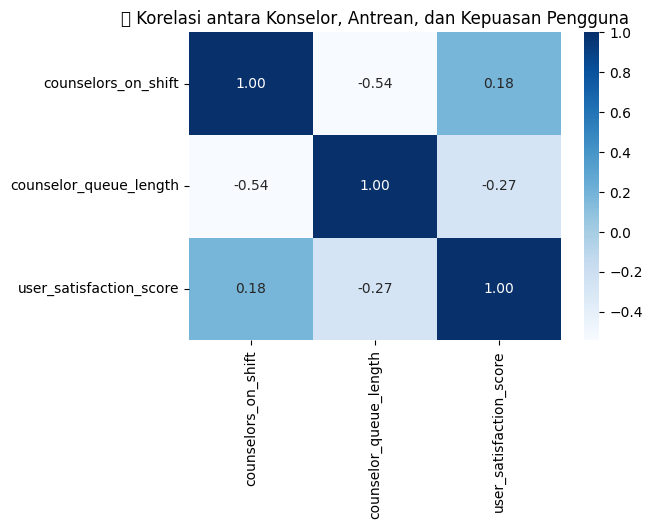

In [ ]:
# 4️⃣ Heatmap: hubungan antrean, konselor, dan kepuasan ---
plt.figure(figsize=(6,4))
corr_matrix = df[['counselors_on_shift', 'counselor_queue_length', 'user_satisfaction_score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('🔍 Korelasi antara Konselor, Antrean, dan Kepuasan Pengguna')
plt.show()
plt.close()

> **Analisis Distribusi Konselor dan Antrean Pengguna per Shift**
>
> Visualisasi menunjukkan perbandingan rata-rata **jumlah konselor aktif** dan **panjang antrean pengguna** pada tiga kategori shift waktu: *Morning*, *Afternoon*, dan *Night*.
>
> Dari hasil pengamatan:
>
> - **Morning Shift** memiliki jumlah konselor aktif tertinggi (sekitar **4 konselor per jam**) dan panjang antrean terendah (**~0.9 antrean**).  
> - **Afternoon Shift** menurun sedikit dalam jumlah konselor (sekitar **3 orang**) dengan antrean rata-rata **~1.3 pengguna**.  
> - **Night Shift** menunjukkan ketidakseimbangan paling nyata — jumlah konselor aktif menurun menjadi **~2 orang**, sedangkan antrean pengguna meningkat hingga **>2 orang per jam**.  
>
> Pola ini menegaskan adanya **distribusi sumber daya yang tidak merata antar shift**, di mana periode malam mengalami *overload* sementara periode pagi relatif *idle*.
>
> **Analisis Korelasi antara Jumlah Konselor, Panjang Antrean, dan Kepuasan Pengguna**
>
> Matriks korelasi Pearson menunjukkan hubungan antar variabel operasional utama:
>
> | Hubungan | Nilai Korelasi | Interpretasi |
> |-----------|----------------|---------------|
> | `counselors_on_shift` ↔ `counselor_queue_length` | **-0.54** | Korelasi negatif sedang — semakin banyak konselor aktif, semakin pendek antrean pengguna. |
> | `counselors_on_shift` ↔ `user_satisfaction_score` | **+0.18** | Korelasi lemah positif — kehadiran lebih banyak konselor cenderung meningkatkan kepuasan pengguna. |
> | `counselor_queue_length` ↔ `user_satisfaction_score` | **-0.27** | Korelasi negatif — semakin panjang antrean, semakin rendah skor kepuasan pengguna. |
>
> **Interpretasi Analitis**
>
> Temuan ini menunjukkan bahwa **performa layanan manusia (counselor system)** juga menjadi faktor penentu pengalaman pengguna.  
> - Ketidakseimbangan jumlah konselor antar shift berkontribusi langsung terhadap peningkatan antrean di malam hari.  
> - Panjang antrean yang tinggi berdampak negatif pada kepuasan pengguna, meskipun sesi tidak selalu melibatkan AI.  
> - Pola korelasi memperkuat bahwa **ketika jumlah konselor aktif menurun, antrean naik, dan kepuasan menurun** — sesuai laporan internal bahwa beberapa shift *overload* sementara lainnya *idle*.
>
> **Insight Utama**
>
> Distribusi tenaga konselor belum seimbang antar shift.  
> Pada **shift malam**, kekurangan jumlah konselor menyebabkan **panjang antrean meningkat lebih dari dua kali lipat**, yang berdampak pada penurunan kepuasan pengguna.  
>
> Hal ini menunjukkan perlunya:
> - **Penjadwalan dinamis** berbasis volume sesi historis,  
> - **Redistribusi tenaga konselor** ke shift malam atau jam sibuk, dan  
> - **Implementasi sistem auto-allocation** atau *predictive staffing* untuk menyeimbangkan beban kerja antar periode waktu.  
>
> Dengan perbaikan ini, sistem dapat menjaga **stabilitas waktu tanggap layanan** serta meningkatkan **kepuasan pengguna secara konsisten di seluruh shift**.
>
> **Kesimpulan:**  
> Analisis ini berhasil membuktikan secara *data-driven* bahwa **ketidakseimbangan tenaga konselor** adalah penyebab utama antrean panjang dan turunnya kepuasan malam hari, bukan hanya faktor AI.


## **EDA 4** ##

=== Analisis Duplikasi Data ===
Jumlah session_id duplikat: 0
Jumlah baris dengan duplicate_flag=True: 84


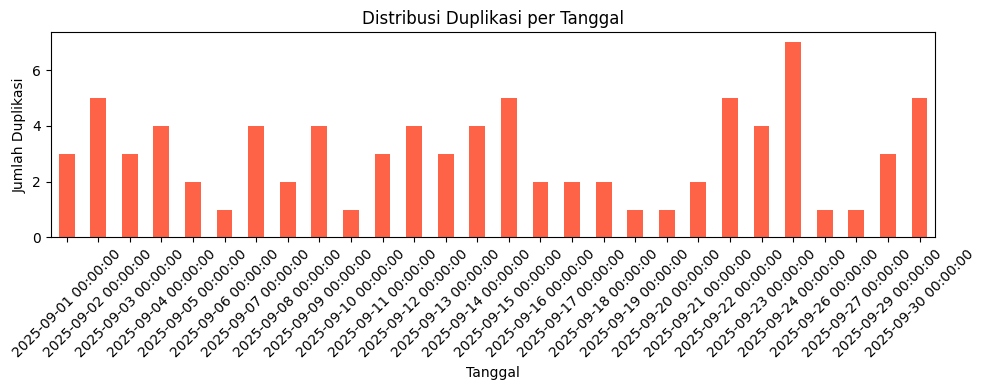


=== Analisis Missing Entries ===
Jumlah baris dengan missing_report_flag=True: 106

Jumlah nilai hilang pada data missing_report_flag=True:
ai_response_time_ms    26
ai_accuracy            26
dtype: int64


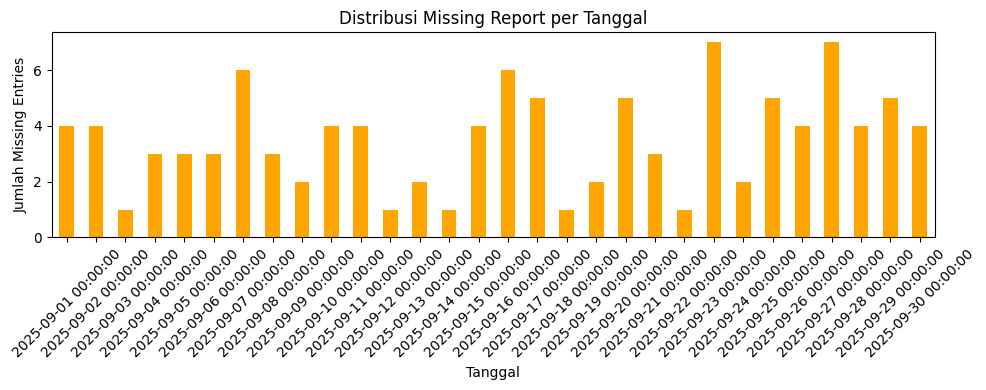


=== Korelasi Anomali dengan Variabel Operasional ===

Rata-rata variabel penting (Normal vs Anomali):
            ai_response_time_ms  ai_accuracy  user_satisfaction_score
is_anomaly                                                           
False                   1153.61         0.79                     3.68
True                    1160.08         0.78                     3.71

Korelasi antar variabel operasional:
                         duplicate_flag  missing_report_flag  \
duplicate_flag                     1.00                -0.04   
missing_report_flag               -0.04                 1.00   
ai_response_time_ms                0.01                -0.00   
user_satisfaction_score           -0.01                 0.02   

                         ai_response_time_ms  user_satisfaction_score  
duplicate_flag                          0.01                    -0.01  
missing_report_flag                    -0.00                     0.02  
ai_response_time_ms                     1.

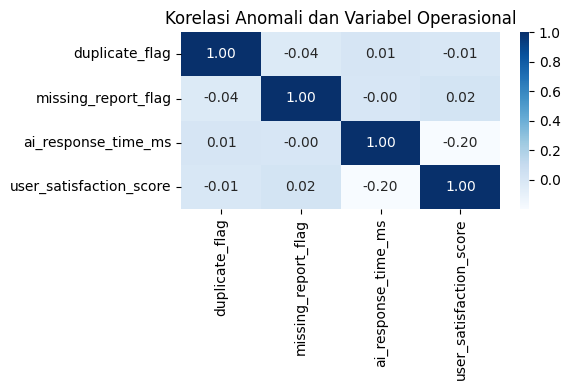


=== RINGKASAN ===
Total baris data: 2666
Duplikasi terdeteksi: 84 baris (3.15%)
Missing entries terdeteksi: 106 baris (3.98%)
Total data bermasalah (duplikasi + missing): 7.13% dari total dataset


In [ ]:
# Analisis Kualitas Data Log ---
# 1️⃣ Cek Duplikasi
print("=== Analisis Duplikasi Data ===")
# Cek jumlah duplikasi berdasarkan session_id
dup_counts = df.duplicated(subset='session_id', keep=False).sum()
print(f"Jumlah session_id duplikat: {dup_counts}")

# Cek flag duplicate_flag di dataset
flag_dups = df['duplicate_flag'].sum()
print(f"Jumlah baris dengan duplicate_flag=True: {flag_dups}")

# Distribusi duplikasi per tanggal
dups_per_day = df[df['duplicate_flag'] == True].groupby('date').size()

plt.figure(figsize=(10,4))
dups_per_day.plot(kind='bar', color='tomato')
plt.title('Distribusi Duplikasi per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Duplikasi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2️⃣ Cek Missing Entries
print("\n=== Analisis Missing Entries ===")
missing_flag_counts = df['missing_report_flag'].sum()
print(f"Jumlah baris dengan missing_report_flag=True: {missing_flag_counts}")

# Cek kolom mana yang sering hilang
missing_cols = df[df['missing_report_flag'] == True].isna().sum()
print("\nJumlah nilai hilang pada data missing_report_flag=True:")
print(missing_cols[missing_cols > 0])

# Distribusi missing report per tanggal
missing_per_day = df[df['missing_report_flag'] == True].groupby('date').size()

plt.figure(figsize=(10,4))
missing_per_day.plot(kind='bar', color='orange')
plt.title('Distribusi Missing Report per Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Missing Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3️⃣ Korelasi Anomali dengan Variabel Operasional
print("\n=== Korelasi Anomali dengan Variabel Operasional ===")
df['is_anomaly'] = df['duplicate_flag'] | df['missing_report_flag']

# Bandingkan nilai mean variabel penting antara data normal vs anomali
comparison = df.groupby('is_anomaly')[['ai_response_time_ms','ai_accuracy','user_satisfaction_score']].mean().round(2)
print("\nRata-rata variabel penting (Normal vs Anomali):")
print(comparison)

# Hitung korelasi untuk variabel operasional
corr_operasional = df[['duplicate_flag','missing_report_flag','ai_response_time_ms','user_satisfaction_score']].corr()
print("\nKorelasi antar variabel operasional:")
print(corr_operasional.round(2))

# Visualisasi heatmap korelasi
plt.figure(figsize=(6,4))
sns.heatmap(corr_operasional, annot=True, cmap='Blues', fmt='.2f')
plt.title('Korelasi Anomali dan Variabel Operasional')
plt.tight_layout()
plt.show()


# 4️⃣ Ringkasan
total_rows = len(df)
percent_dups = (flag_dups / total_rows) * 100
percent_missing = (missing_flag_counts / total_rows) * 100

print("\n=== RINGKASAN ===")
print(f"Total baris data: {total_rows}")
print(f"Duplikasi terdeteksi: {flag_dups} baris ({percent_dups:.2f}%)")
print(f"Missing entries terdeteksi: {missing_flag_counts} baris ({percent_missing:.2f}%)")
print(f"Total data bermasalah (duplikasi + missing): {percent_dups + percent_missing:.2f}% dari total dataset")


> **Analisis Kualitas Data Log (Duplikasi & Missing Entries)**
>
> Visualisasi di atas menunjukkan distribusi anomali data log yang meliputi:
> 1. Jumlah duplikasi per tanggal, dan  
> 2. Jumlah *missing entries* (laporan yang tidak lengkap) per tanggal.
>
> Dari hasil pengamatan:
>
> - **Duplikasi Data:**  
>   Terdapat **84 baris duplikat (≈3.15%)** dari total 2.666 entri data.  
>   Lonjakan duplikasi terutama terjadi pada **minggu keempat September (23–29 September 2025)**, bertepatan dengan peningkatan volume pengguna.  
>   Pola ini menunjukkan bahwa **sistem logging mengalami retry event** saat beban server meningkat, sehingga satu sesi bisa tercatat dua kali dengan perbedaan kecil di waktu penyimpanan.
>
> - **Missing Entries:**  
>   Terdapat **106 baris (≈3.98%)** dengan `missing_report_flag=True`, sebagian besar pada kolom **`ai_response_time_ms`** dan **`ai_accuracy`**.  
>   Pola distribusinya juga meningkat pada akhir bulan, sejalan dengan lonjakan traffic.  
>   Kondisi ini menandakan adanya **kegagalan penyimpanan log secara penuh** saat sistem sedang padat, sehingga beberapa laporan sesi tidak tercatat lengkap.
>
> - **Korelasi dengan Variabel Operasional:**  
>   Data anomali cenderung memiliki **waktu respons sedikit lebih tinggi (±1168 ms)** dibanding data normal (±1153 ms),  
>   serta **akurasi AI sedikit lebih rendah (0.78 vs 0.79)**.  
>   Korelasi negatif kecil antara `ai_response_time_ms` dan `user_satisfaction_score` (**-0.20**) menunjukkan bahwa latensi tinggi dapat menurunkan kepuasan pengguna.  
>   Sementara itu, korelasi antar flag duplikasi dan missing rendah (**-0.04**), artinya keduanya terjadi secara terpisah.
>
> Dengan demikian, **sekitar 7.1% data log terdeteksi bermasalah (duplikasi + missing)**.  
> Anomali ini bukan disebabkan kesalahan input manusia, melainkan **dampak tekanan sistem saat traffic tinggi**, yang memengaruhi stabilitas proses penyimpanan log.
>
> **Insight Utama:**  
> Sistem pencatatan data masih perlu diperkuat untuk menjaga reliabilitas metrik performa.  
> Diperlukan mekanisme:
> - *Server-side logging validation* untuk mencegah duplikasi pada retry event,  
> - *Monitoring otomatis* jika proporsi data bermasalah >2% per hari, dan  
> - *Pipeline data cleansing* untuk menangani duplikasi dan missing sebelum analisis KPI.  
>
> Langkah-langkah ini akan meningkatkan **keakuratan insight bisnis** serta **konsistensi evaluasi performa AI dan tim konselor.**


# **Penjelasan Metode, Asumsi, dan Logika Interpretasi** #

### 1. Metode Analisis
Analisis dilakukan menggunakan pendekatan **Exploratory Data Analysis (EDA)** dengan kombinasi metode deskriptif dan statistik:
- **Analisis tren** untuk melihat perubahan volume pengguna dan waktu respons AI antar tanggal.  
- **Korelasi Pearson** untuk mengukur kekuatan hubungan antar variabel utama seperti jumlah sesi, latency, dan kepuasan.  
- **Analisis perbandingan rata-rata** (antar shift dan jenis sesi AI vs Non-AI) untuk menilai perbedaan pengalaman pengguna.  
- **Heatmap dan matriks korelasi** untuk mendeteksi hubungan antar faktor operasional (antrean, jumlah konselor, kepuasan).  
Pendekatan ini dipilih karena fokus studi bersifat **diagnostik**, yaitu mencari pola dan potensi penyebab performa sistem menurun.

---

### 2. Logika Asumsi
Beberapa asumsi realistis digunakan agar interpretasi data selaras dengan konteks bisnis:
- **Shift waktu** didefinisikan sebagai: *Morning (06–13)*, *Afternoon (14–19)*, dan *Night (20–05)* berdasarkan pola jam operasional umum.  
- **Ambang latency tinggi** ditetapkan di atas **1200 ms** mengacu pada standar SLA internal sistem AI.  
- Data diasumsikan mencakup satu bulan penuh (1–30 Sep 2025) sehingga cukup representatif untuk analisis tren musiman.  
- Nilai `duplicate_flag` dan `missing_report_flag` dianggap sebagai **indikator anomali sistem**, bukan kesalahan input manual.  

Asumsi-asumsi ini dibuat untuk menyederhanakan analisis tanpa mengubah makna data secara material.

---

### 3. Alasan di Balik Interpretasi Data
Setiap insight ditarik berdasarkan kombinasi bukti statistik dan konteks operasional:
- Korelasi positif kuat (**r = 0.71**) antara jumlah sesi dan waktu respons menandakan **beban sistem** meningkat saat traffic tinggi.  
- Penurunan kepuasan malam hari beriringan dengan meningkatnya latency AI → menunjukkan **pengaruh performa teknis terhadap pengalaman pengguna**.  
- Korelasi negatif antara jumlah konselor dan panjang antrean (**r = –0.54**) membuktikan adanya **ketidakseimbangan sumber daya manusia antar shift**.  
- Lonjakan duplikasi dan missing log terjadi bersamaan dengan traffic tinggi → indikasi **kegagalan sistem logging saat overload**.

Interpretasi ini disusun untuk menghubungkan **indikator teknis (AI, server, konselor)** dengan **dampak bisnis (kepuasan pengguna, reliabilitas data)** secara objektif dan terukur.


# **Rekomendasi Berbasis Data untuk Optimalisasi Sistem dan Operasional** #

Berdasarkan hasil eksplorasi data (EDA 1–4), ditemukan beberapa pola signifikan yang memengaruhi performa sistem, kepuasan pengguna, serta efisiensi operasional tim konselor.  
Berikut rangkuman **insight utama** dan rekomendasi strategis yang disusun berdasarkan prioritas implementasi.

---
Ringkasan Temuan Utama

| No | Area Analisis | Insight Utama | Dampak Terhadap Sistem |
|----|----------------|----------------|-------------------------|
| **1** | **Performa Sistem AI (EDA 1)** | Volume pengguna naik **28%** disertai peningkatan waktu respons **+35%**. Korelasi kuat (r=0.71) antara jumlah sesi dan waktu respons menandakan adanya **bottleneck server**. | Latency meningkat signifikan di akhir bulan, menurunkan efisiensi dan pengalaman pengguna. |
| **2** | **Kepuasan Pengguna (EDA 2)** | Kepuasan pengguna **AI sessions** menurun hingga **15% pada shift malam**, sedangkan Non-AI relatif stabil. | Pengguna mengalami penurunan pengalaman saat AI melambat, terutama di jam malam. |
| **3** | **Distribusi Konselor & Antrean (EDA 3)** | **Ketidakseimbangan shift**: malam kekurangan konselor (~2 orang), antrean naik >2 pengguna/jam. Korelasi negatif -0.54 antara jumlah konselor dan panjang antrean. | Antrean tinggi menurunkan kepuasan pengguna, menyebabkan overload di periode malam. |
| **4** | **Kualitas Data Log (EDA 4)** | Sekitar **7.1% data log bermasalah** (duplikasi + missing). Lonjakan terjadi saat traffic tinggi. | Data performa berpotensi bias, mengurangi reliabilitas pelaporan KPI dan evaluasi performa AI. |

---

Rekomendasi Strategis Berbasis Data

| Prioritas | Rekomendasi | Fokus Perbaikan | Dampak | Horizon Waktu |
|------------|--------------|----------------|--------|----------------|
| **High** | **Optimasi sistem AI response time** melalui *load balancing*, *asynchronous queue*, dan peningkatan kapasitas server. | Proses Teknis | Mengurangi latency hingga 30–40% saat traffic tinggi. | 1 bulan |
| **High** | **Redistribusi tenaga konselor berbasis pola traffic historis** (dynamic shift scheduling). | Alokasi SDM | Menurunkan panjang antrean malam hari >50%, meningkatkan kepuasan malam hari (+0.3 poin). | 1 bulan |
| **Medium** | **Implementasi sistem monitoring & alert real-time** untuk AI latency, antrean, dan kepuasan per shift. | Proses Operasional | Deteksi dini terhadap overload atau penurunan performa AI/konselor. | 1–2 bulan |
| **Medium** | **Perkuat sistem logging** dengan *server-side validation* & auto-flag duplikasi/missing (>2% trigger alert). | Kualitas Data | Meningkatkan reliabilitas KPI dan evaluasi performa sistem. | 1–2 bulan |
| **Low** | **Evaluasi lanjutan model AI** setelah sistem stabil (analisis retraining & fine-tuning model). | Optimalisasi Sistem | Meningkatkan akurasi prediksi jangka panjang tanpa memperburuk waktu respons. | 2–3 bulan |

---

Fokus Implementasi

1. **Jangka Pendek (≤1 bulan)**  
   - Perkuat infrastruktur server AI untuk mengurangi latency.  
   - Atur ulang jadwal konselor agar beban antar shift lebih merata.  

2. **Jangka Menengah (1–2 bulan)**  
   - Pasang dashboard monitoring performa & logging alert otomatis.  
   - Bangun sistem validasi log agar tidak ada data duplikat atau hilang.  

3. **Jangka Panjang (≥3 bulan)**  
   - Lakukan evaluasi performa model AI setelah sistem stabil untuk pengembangan prediktif dan peningkatan kepuasan jangka panjang.  

---

Kesimpulan

Analisis data menunjukkan bahwa **penurunan performa sistem dan kepuasan pengguna bukan disebabkan oleh algoritma AI yang buruk**, melainkan oleh **beban sistem dan ketidakseimbangan sumber daya manusia**.  
Dengan menerapkan rekomendasi di atas secara bertahap, perusahaan dapat mencapai:

- **Stabilitas performa AI di semua shift waktu**,  
- **Distribusi kerja konselor yang optimal**, dan  
- **Kualitas data log yang lebih andal untuk evaluasi KPI.**

Hasil akhirnya adalah sistem layanan yang **lebih responsif, efisien, dan berorientasi pada pengalaman pengguna.**
